In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

### Reweighting

An example of the training data, consisting of $N$ hadronization events (in the dataset below $N = 10,000$), is:
$$
\boldsymbol{z} = 
  \begin{pmatrix}
    \boldsymbol{z}_1 = 
    \begin{pmatrix} 
        \big\{ m_T^{h_1}, z^{h_1}_{\text{accept}}, z^{1, h_1}_{\text{reject}}, z^{2, h_1}_{\text{reject}}, \cdots, 									  z^{n_{h_1}, h_1}_{\text{reject}}\big\} \\
        \big\{ m_T^{h_2}, z^{h_2}_{\text{accept}}, z^{1, h_2}_{\text{reject}}, z^{2, h_2}_{\text{reject}}, \cdots, z^{n_{h_2}, h_2}_{\text{reject}} \big\} \\	
        \big\{ m_T^{h_3}, z^{h_3}_{\text{accept}}, z^{1, h_3}_{\text{reject}}, z^{2, h_3}_{\text{reject}}, \cdots, z^{n_{h_3}, h_3}_{\text{reject}} \big\} 
        \end{pmatrix}_1 \\
    \boldsymbol{z}_2 = 
    \begin{pmatrix} 
      \big\{ m_T^{h_1}, z^{h_1}_{\text{accept}}, z^{1, h_1}_{\text{reject}}, z^{2, h_1}_{\text{reject}}, \cdots, z^{n_{h_1}, h_1}_{\text{reject}}\big\} \\
      \vdots \\	
      \big\{ m_T^{h_4}, z^{h_4}_{\text{accept}}, z^{1, h_4}_{\text{reject}}, z^{2, h_4}_{\text{reject}}, \cdots, z^{n_{h_4}, h_4}_{\text{reject}} \big\} 
      \end{pmatrix}_2 \\
      \vdots \\
    \boldsymbol{z}_N = \cdots
  \end{pmatrix},
$$
$$
\boldsymbol{y}_\text{sim} = 
  \begin{pmatrix}
    \boldsymbol{y}_1 = N_{h,1} = 3\\
    \boldsymbol{y}_2 = N_{h,2} = 4 \\
    \vdots \\
    \boldsymbol{y}_N = N_{h,N} = 2
\end{pmatrix}
$$
Note that each array $\boldsymbol{z}_i$ is zero-padded to a fixed length of size $105$ and each accept-reject array is zero-padded to a fixed length of size $101$ (the maximum number of rejections is 100).

In [ ]:
# Load accept-reject and hadron data at (a = 0.72, b = 0.88, sigma = 0.335, N = 1e4) 
accept_reject_monash_prime_PATH = './posthoc_data/pgun_qqbar_mT2_accept_reject_a_0.72_b_0.88_sigma_0.335_N_1e4.npy'
pgun_accept_reject_monash_prime = np.load(accept_reject_monash_prime_PATH, mmap_mode = "r")

fPrel_monash_prime_PATH = './posthoc_data/pgun_qqbar_fPrel_a_0.72_b_0.88_sigma_0.335_N_1e4.npy'
pgun_fPrel_monash_prime = np.load(fPrel_monash_prime_PATH, mmap_mode = "r")

filename_hadrons_monash_prime = './posthoc_data/pgun_qqbar_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e4.npy'
pgun_hadrons_monash_prime = np.load(filename_hadrons_monash_prime, mmap_mode="r")

# Load the hadron data from Monash for comparison (a = 0.68, b = 0.98, sigma = 0.335, N = 1e4)
filename_hadrons_monash = './posthoc_data/pgun_qqbar_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e4.npy'
pgun_hadrons_monash = np.load(filename_hadrons_monash, mmap_mode="r")

In [ ]:
# Check the shapes
print("Accepted and rejected z data shape (Monash'):", pgun_accept_reject_monash_prime.shape)
print("Hadron data shape (Monash'):", pgun_hadrons_monash_prime.shape)

Accepted and rejected z data shape (Monash'): (10000, 105, 101)
Hadron data shape (Monash'): (10000, 75, 5)


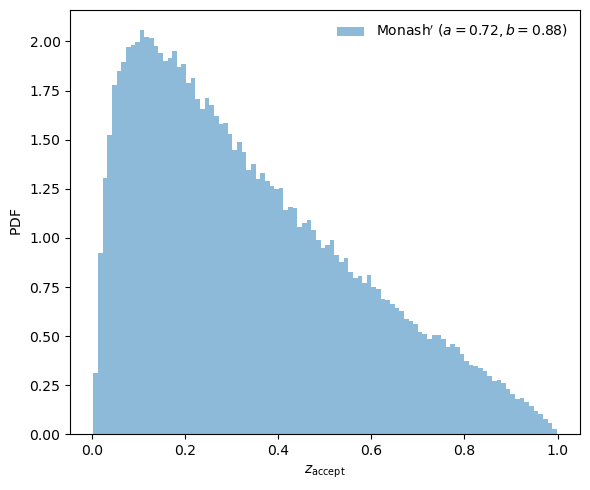

In [ ]:
# Histrogram accepted z-values across all events
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.hist(pgun_accept_reject_monash_prime[:,:,1][pgun_accept_reject_monash_prime[:,:,1] > 0.0], 100, alpha = 0.5, density = True, label = r"$\mathrm{Monash'}$ $(a = 0.72, b = 0.88)$")
ax.set_xlabel(r'$z_{\mathrm{accept}}$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.legend(frameon = False)
fig.tight_layout()

In [ ]:
Nevent = 10000
# Collect multiplicity data
mult_monash = np.array([len(pgun_hadrons_monash[i,:][np.abs(pgun_hadrons_monash[i,:,0]) > 0.0]) for i in range(Nevent)])
mult_monash_prime = np.array([len(pgun_hadrons_monash_prime[i,:][np.abs(pgun_hadrons_monash_prime[i,:,0]) > 0.0]) for i in range(Nevent)])

In [ ]:
print(mult_monash.shape)
print(mult_monash_prime.shape)

(50000,)
(50000,)
(50000,)


3.0 28.0
2.0 29.0


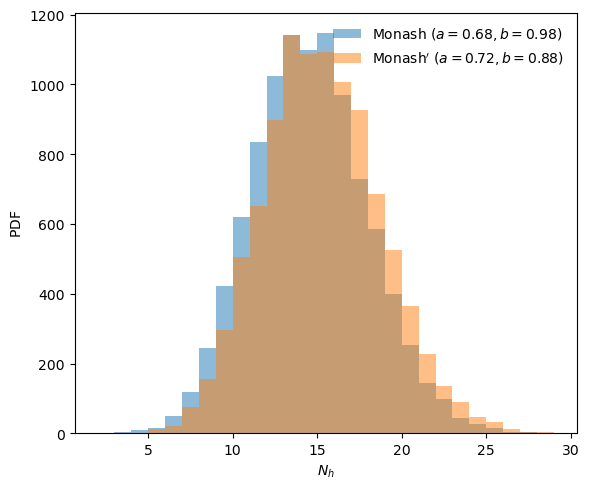

In [11]:
# Histrogram hadron multiplicity
fig, ax = plt.subplots(1,1,figsize=(6,5))

_, bins_monash = np.histogram(mult_monash)
_, bins_monash_prime = np.histogram(mult_monash_prime)

min_monash, max_monash = bins_monash[0], bins_monash[-1]
min_monash_prime, max_monash_prime = bins_monash_prime[0], bins_monash_prime[-1]

print(min_monash, max_monash)
print(min_monash_prime, max_monash_prime)

min = np.min([min_monash, min_monash_prime])
max = np.max([max_monash, max_monash_prime])

bins = np.linspace(min, max, int((max - min)+1))

counts, _, _ = ax.hist(mult_monash, bins, alpha = 0.5, density = False, label = r'$\mathrm{Monash}$ $(a = 0.68, b = 0.98)$')
ax.hist(mult_monash_prime, bins = bins, alpha = 0.5, density = False, label = r"$\mathrm{Monash'}$ $(a = 0.72, b = 0.88)$")
ax.set_xlabel(r'$N_h$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.legend(frameon = False)
fig.tight_layout()

The reweighting module computes a weight array, given the base $B$ and perturbed $P$ parameterizations, according to 
$$
\boldsymbol{w} = \begin{pmatrix}
    w_1 \\
    w_2 \\
    \vdots \\
    w_N
  \end{pmatrix}, \text{ where } \\
  w_n = \prod_{i = 1}^{N_{h,n}} \left(\frac{f(z^{h_i}_\text{accept}; \{a, b\}_P)}{f(z^{h_i}_\text{accept}; \{a, b\}_{B})}\right)
  \prod_{j = 1}^{n_{h_i}} \left(\frac{\hat{f} - f(z^{j, h_i}_\text{reject}; \{a, b\}_P)}{\hat{f} - f(z^{j, h_i}_\text{reject}; \{a, b\}_{B}}\right)
$$
where $\hat{f}$ is the oversampling factor associated with the sampling of $z$ (here the over-sampling factor is 10). For each event, the accepcted and rejected $z$-values as well as the transverse mass $m_T^2 = p_x^2 + p_y^2 + m^2$ of each hadron is required to compute the event weight.

In [12]:
class LundWeight(nn.Module):
    def __init__(self, params_base, params, over_sample_factor):
        super(LundWeight, self).__init__()
        self.params_base = params_base
        self.params_a = torch.nn.Parameter(params[0].clone(), requires_grad=True)
        self.params_b = torch.nn.Parameter(params[1].clone(), requires_grad=True)
        self.over_sample_factor = over_sample_factor

        self.AFROMZERO = 0.02
        self.EXPMAX = 50.
        self.AFROMC = 0.01
    
    def zMaxCalc(self, a, b, c):
        # Normalization for Lund fragmentation function so that f <= 1.
        # Special cases for a = 0 and a = c.
        aIsZero = (a < self.AFROMZERO)
        aIsC = (torch.abs(a - c) < self.AFROMC)
        # Determine position of maximum.
        if aIsZero:
            return b / c if c > b else 1.
        elif aIsC:
            return b / (b + c)
        else:
            zMax = 0.5 * (b + c - torch.sqrt(torch.pow(b - c, 2) + 4 * a * b)) / (c - a)
            if torch.isnan(zMax).any():
                print('zMax_1', zMax)
                print('a', a, 'b', b, 'c', c)
                exit()

            # Adjust zMax in numerically unstable regions 
            zMax = torch.where((zMax > 0.9999) & (b > 100.), torch.min(zMax, 1. - a / b), zMax)
            return zMax
    
    def likelihood(self, z, mT, a, b, c = torch.tensor(1., requires_grad=True), z_mask = None, mT_mask = None):
        """
        Compute the likelihood of the Lund fragmentation function

        Args:
            z (torch.Tensor): Input tensor
            mT (torch.Tensor): Transverse mass tensor (can be different shape from z)
            a (torch.Tensor): Parameter a
            b (torch.Tensor): Parameter b
            c (torch.Tensor): Parameter c (default: torch.tensor(1., requires_grad=True))
            z_mask (torch.Tensor, optional): Boolean mask tensor for z (default: None)
            mT_mask (torch.Tensor, optional): Boolean mask tensor for mT (default: None)

        Returns:
            likelihood (torch.Tensor): Computed likelihood values (shape determined by broadcasting rules)
        """

        # Determine the shape after broadcasting
        broadcast_shape = torch.broadcast_shapes(z.shape, mT.shape)

        # If no masks are provided, consider all elements
        if z_mask is None:
            z_mask = torch.ones(z.shape, dtype=torch.bool, device=z.device)
        if mT_mask is None:
            mT_mask = torch.ones(mT.shape, dtype=torch.bool, device=mT.device)

        # Broadcast z, mT, and their masks to the common shape
        z_broad = z.expand(broadcast_shape)
        mT_broad = mT.expand(broadcast_shape)
        z_mask_broad = z_mask.expand(broadcast_shape)
        mT_mask_broad = mT_mask.expand(broadcast_shape)
    
        # Combine masks
        combined_mask = z_mask_broad & mT_mask_broad
        
        # Create a tensor to store the results, initialized with zeros
        likelihood = torch.zeros(broadcast_shape, dtype=z.dtype, device=z.device)
    
        # Only perform calculations on unmasked elements
        z_unmasked = z_broad[combined_mask]
        mT_unmasked = mT_broad[combined_mask]
    
        # Check if we have any unmasked elements to process
        if z_unmasked.numel() > 0:
            # Adjust b-parameter
            b_exp = b * mT_unmasked
            
            # Special case for a = 0.
            aIsZero = (a < self.AFROMZERO)
            
            # Determine position of maximum.
            zMax = self.zMaxCalc(a, b_exp, c)
            
            # Be careful of -inf values in aCoeff, very nasty bug to find.
            aCoef = torch.log(1. - z_unmasked) - torch.log(1. - zMax)
            if torch.isneginf(aCoef).any():
                print('aCoef is returning -inf value, please check that all z < 1.')
                print('aCoeff', aCoef)
    
            bCoef = (1. / zMax) - (1. / z_unmasked)
            cCoef = torch.log(zMax) - torch.log(z_unmasked)
            fExp = b_exp * bCoef + c * cCoef
            
            # Special cases for a = 0.
            if ~aIsZero:
                fExp = fExp + a * aCoef
            
            # Feed through numerical stabilizer
            fVal = torch.exp(torch.clamp(fExp, min=-self.EXPMAX, max=self.EXPMAX))
            
            # Assign computed values back to the likelihood tensor
            likelihood[combined_mask] = fVal
        
        return likelihood

    def forward(self, z, fPrel):
        """
        Forward pass of the weight module -- consists of computing the event weights for a given batch
        of training data.
        """
        batch_size = z.shape[0]
        weights = torch.ones(batch_size)

        # Extract the mT2 values 
        mT2 = z[:, :, 0]
        # Reshape into column tensor
        mT2 = mT2.view(mT2.shape[0], mT2.shape[1], 1)
        # Create a mask for zero values
        mT2_mask = mT2 != 0.

        # Extract the accepted z values
        z_accept = z[:, :, 1]
        # Reshape into column tensor
        z_accept = z_accept.view(z_accept.shape[0], z_accept.shape[1], 1)
        # Remove any zero values
        z_accept_mask = z_accept != 0.

        # Extract the rejected z values
        z_reject = z[:, :, 2:]
        # Reshape into column tensor
        z_reject = z_reject.view(z_reject.shape[0], z_reject.shape[1], z_reject.shape[2])
        # Remove any zero values along the event index
        z_reject_mask = z_reject != 0.

        fPrel_reject = fPrel[:, :, 1:]
        fPrel_reject = fPrel_reject.view(fPrel_reject.shape[0], fPrel_reject.shape[1], fPrel_reject.shape[2])
        fPrel_reject_mask = fPrel_reject != 0.

        # Compute the accept and reject weights
        accept_weights = self.likelihood(z_accept, mT2, self.params_a, self.params_b, z_mask = z_accept_mask, mT_mask = mT2_mask) / self.likelihood(z_accept, mT2, self.params_base[0], self.params_base[1], z_mask = z_accept_mask, mT_mask = mT2_mask)    
        reject_weights = ((self.over_sample_factor * (fPrel_reject * fPrel_reject_mask.masked_fill(z_accept_mask == 0, 1))) - self.likelihood(z_reject, mT2, self.params_a, self.params_b, z_mask = z_reject_mask, mT_mask = mT2_mask)) / ((self.over_sample_factor * (fPrel_reject * fPrel_reject_mask.masked_fill(z_accept_mask == 0, 1))) - self.likelihood(z_reject, mT2, self.params_base[0], self.params_base[1], z_mask = z_reject_mask, mT_mask = mT2_mask))

        # Flatten the weights
        accept_weights = (accept_weights * z_accept_mask).masked_fill(z_accept_mask == 0, 1).prod(dim=2).prod(dim=1)
        reject_weights = (reject_weights * z_reject_mask).masked_fill(z_reject_mask == 0, 1).prod(dim=2).prod(dim=1)
            
        # The final event weight is the product of accepted and rejected weights
        weights = accept_weights * reject_weights
    
        return weights

In [ ]:
# Set base parameterization 
params_base_1 = torch.tensor([0.72, 0.88]) # Monash' (a,b)

# Set parameters to reweiigh to (data)
params_target = torch.tensor([0.68, 0.98]) # Monash (a,b)

# Set the over sample factor (for the pgun_qqbar datasets this is 10.)
over_sample_factor = 10.

# Initialize the reweighting module
reweighter = LundWeight(params_base_1, params_target, over_sample_factor = over_sample_factor)

In [ ]:
# Consider a 'batch' consisting of 10,000 events
nevents = 10000

# Monash'
pgun_accept_reject_monash_prime_torch = torch.from_numpy(pgun_accept_reject_monash_prime[0:nevents].copy())
pgun_fPrel_monash_prime_torch = torch.from_numpy(pgun_fPrel_monash_prime[0:nevents].copy())

# Check for values of 1 and correct
epsilon = 1e-10
# Monash'
pgun_accept_reject_monash_prime_torch[pgun_accept_reject_monash_prime_torch == 1] -= epsilon
pgun_mult_monash_prime_torch = torch.from_numpy(mult_monash_prime[0:nevents].copy())
pgun_mult_monash_prime_torch = torch.reshape(pgun_mult_monash_prime_torch, (nevents,1))

In [16]:
# Check the shapes
print(pgun_accept_reject_monash_prime_torch.shape)
print(pgun_fPrel_monash_prime_torch.shape)
print(pgun_mult_monash_prime_torch.shape)

torch.Size([10000, 105, 101])
torch.Size([10000, 105, 100])
torch.Size([10000, 1])


In [18]:
# Compute the weight array
#torch.set_printoptions(threshold=100000, sci_mode=False)
#torch.set_printoptions(profile='default')
weights = reweighter.forward(pgun_accept_reject_monash_prime_torch, pgun_fPrel_monash_prime_torch)

In [19]:
# Compute the reweighting metrics
print(weights.detach().numpy().shape)
print(weights.detach().numpy())
one_minus_mu = 1. - np.sum(weights.detach().numpy()) / len(weights.detach().numpy())
Neff = (np.sum(weights.detach().numpy())**2 / np.sum(weights.detach().numpy()**2)) / len(weights.detach().numpy())
print('1 - mu:', one_minus_mu)
print('Neff:', Neff)

(10000,)
[1.12693049 1.44607619 0.69629616 ... 0.79463173 1.416112   0.72541872]
1 - mu: 0.001307191439642863
Neff: 0.8570689943261898


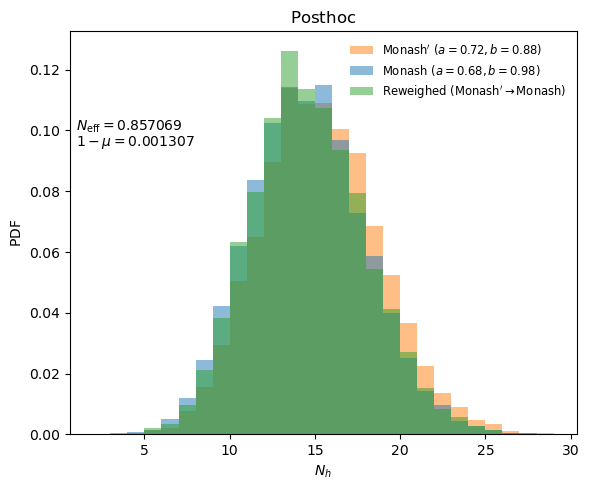

In [ ]:
# Check the reweighed multiplicity historgram
fig, ax = plt.subplots(1,1,figsize=(6,5))

counts, bins, _ = ax.hist(mult_monash_prime[0:nevents], bins = bins, alpha = 0.5, label = r"$\mathrm{Monash'}$ $(a = 0.72, b = 0.88)$", color = 'tab:orange', density = True)
ax.hist(mult_monash[0:nevents], bins = bins, alpha = 0.5, label = r'$\mathrm{Monash}$ $(a = 0.68, b = 0.98)$', color = 'tab:blue', density = True)
ax.hist(pgun_mult_monash_prime_torch.detach().numpy(), bins = bins, weights = weights.detach().numpy(), alpha = 0.5, label = r"$\mathrm{Reweighed}$ $(\mathrm{Monash}' \rightarrow \mathrm{Monash})$", color = 'tab:green', density = True)

ax.text(1.0, 0.10, rf'$N_{{\mathrm{{eff}}}} = {Neff:3f}$', fontsize = 10)
ax.text(1.0, 0.095, rf'$1 - \mu = {one_minus_mu:3f}$', fontsize = 10)

ax.set_xlabel(r'$N_h$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.legend(frameon = False, fontsize = 'small')
ax.set_title(r'$\mathrm{Posthoc}$')
fig.tight_layout()

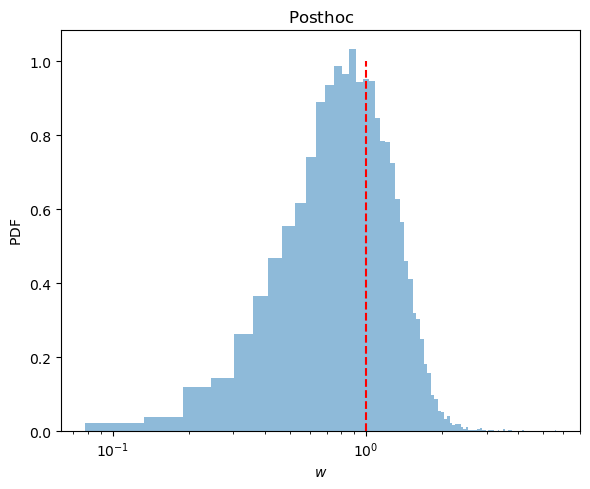

In [ ]:
# Check the distribution of weights
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.hist(weights.detach().numpy(), 100, alpha = 0.5, density=True)
ax.set_xlabel(r'$w$')
ax.set_ylabel(r'$\mathrm{PDF}$')
ax.set_xscale('log')
ax.vlines(1., 0., 1., color = 'red', linestyle = '--')
ax.set_title(r'$\mathrm{Posthoc}$')
fig.tight_layout()